<a href="https://colab.research.google.com/github/schwamb/311-service-project/blob/main/311_service_request.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from credentials import username, password
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [15]:
# Read the csv file into a pandas DataFrame
# import io
service_requests_starter = pd.read_csv('Resources/311_Service_Requests.csv')

index = service_requests_starter.index
number_of_rows = len(service_requests_starter) 
print(number_of_rows)

C:\Users\chamb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,12,18,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


4314562


In [16]:
service_requests_starter.head()


,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,CITY,...,PRECINCT,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,SR20-04353987,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,06/16/2020 08:07:09 AM,124 E 34TH ST,NaN,...,41.0,NaN,11,2,6,1.178058e+06,1.882510e+06,41.832932,-87.622178,"(41.83293224964682, -87.62217834335817)"
1,SR20-05291417,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,10/18/2020 10:17:23 PM,10/18/2020 10:30:43 PM,10/18/2020 10:17:23 PM,2111 W Lexington ST,Chicago,...,46.0,NaN,22,1,10,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
2,SR19-03141127,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,12/15/2019 01:09:11 PM,12/15/2019 01:30:44 PM,12/15/2019 01:09:12 PM,2111 W Lexington ST,Chicago,...,46.0,NaN,13,1,12,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
3,SR19-02121793,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,08/05/2019 05:32:55 AM,08/05/2019 06:30:12 AM,08/05/2019 05:32:56 AM,2111 W Lexington ST,Chicago,...,46.0,NaN,5,2,8,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
4,SR21-00306938,Sewer Cleaning Inspection Request,CHECKFOR,DWM - Department of Water Management,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,02/23/2021 05:17:18 PM,2022 W WABANSIA AVE,NaN,...,36.0,NaN,15,3,2,1.162486e+06,1.911424e+06,41.912613,-87.678504,"(41.91261283416994, -87.67850416366063)"


In [17]:
for col in service_requests_starter.columns:
    print(col)

SR_NUMBER
SR_TYPE
SR_SHORT_CODE
OWNER_DEPARTMENT
STATUS
CREATED_DATE
LAST_MODIFIED_DATE
CLOSED_DATE
STREET_ADDRESS
CITY
STATE
ZIP_CODE
STREET_NUMBER
STREET_DIRECTION
STREET_NAME
STREET_TYPE
DUPLICATE
LEGACY_RECORD
LEGACY_SR_NUMBER
PARENT_SR_NUMBER
COMMUNITY_AREA
WARD
ELECTRICAL_DISTRICT
ELECTRICITY_GRID
POLICE_SECTOR
POLICE_DISTRICT
POLICE_BEAT
PRECINCT
SANITATION_DIVISION_DAYS
CREATED_HOUR
CREATED_DAY_OF_WEEK
CREATED_MONTH
X_COORDINATE
Y_COORDINATE
LATITUDE
LONGITUDE
LOCATION


In [18]:
service_requests = service_requests_starter[['SR_NUMBER', 'SR_TYPE', 'STATUS', 'CREATED_DATE', 'CLOSED_DATE', 'WARD', 'CREATED_MONTH', 'CREATED_DAY_OF_WEEK', 'CREATED_HOUR', 'DUPLICATE', 'LEGACY_RECORD']].copy()
service_requests.head()

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
1,SR20-05291417,311 INFORMATION ONLY CALL,Completed,10/18/2020 10:17:23 PM,10/18/2020 10:17:23 PM,28.0,10,1,22,False,False
2,SR19-03141127,311 INFORMATION ONLY CALL,Completed,12/15/2019 01:09:11 PM,12/15/2019 01:09:12 PM,28.0,12,1,13,False,False
3,SR19-02121793,311 INFORMATION ONLY CALL,Completed,08/05/2019 05:32:55 AM,08/05/2019 05:32:56 AM,28.0,8,2,5,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False


In [19]:
info_only = service_requests[service_requests['SR_TYPE'] == '311 INFORMATION ONLY CALL'].index
service_requests.drop(info_only , inplace=True)

In [20]:
service_requests

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4314554,SR21-00860518,Aircraft Noise Complaint,Completed,05/22/2021 05:31:37 AM,05/22/2021 05:31:37 AM,41.0,5,7,5,False,False
4314556,SR21-00860617,Aircraft Noise Complaint,Completed,05/22/2021 06:46:33 AM,05/22/2021 06:46:33 AM,NaN,5,7,6,False,False
4314558,SR21-00860645,Abandoned Vehicle Complaint,Open,05/22/2021 06:56:31 AM,NaN,27.0,5,7,6,False,False
4314559,SR21-00860672,Tree Planting Request,Open,05/22/2021 07:04:25 AM,NaN,49.0,5,7,7,False,False


In [21]:
aircraft_noise = service_requests[service_requests['SR_TYPE'] == 'Aircraft Noise Complaint'].index
service_requests.drop(aircraft_noise , inplace=True)

In [22]:
open = service_requests[service_requests['STATUS'] == 'Open'].index
service_requests.drop(open , inplace=True)

In [23]:
open = service_requests[service_requests['STATUS'] == 'Canceled'].index
service_requests.drop(open , inplace=True)

In [24]:
dupes = service_requests[service_requests['DUPLICATE'] == True].index
service_requests.drop(dupes , inplace=True)

In [25]:
service_requests = service_requests.drop_duplicates(subset=['SR_NUMBER'])

In [26]:
service_requests

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4314066,SR21-00754026,Abandoned Vehicle Complaint,Completed,05/07/2021 12:43:51 PM,05/22/2021 04:10:24 AM,23.0,5,6,12,False,False
4314067,SR21-00758162,Abandoned Vehicle Complaint,Completed,05/08/2021 08:53:14 AM,05/22/2021 04:11:15 AM,10.0,5,7,8,False,False
4314075,SR21-00860358,Abandoned Vehicle Complaint,Completed,05/22/2021 01:33:06 AM,05/22/2021 02:34:50 AM,37.0,5,7,1,False,False
4314278,SR21-00860355,Abandoned Vehicle Complaint,Completed,05/22/2021 01:29:18 AM,05/22/2021 02:30:50 AM,37.0,5,7,1,False,False


In [27]:
service_requests.SR_TYPE.unique()

array(['Graffiti Removal Request', 'Sewer Cleaning Inspection Request',
       'Dead Animal Pick-Up Request', 'Tree Removal Request',
       'Tree Trim Request', 'Street Light Out Complaint',
       'Water in Basement Complaint', 'City Vehicle Sticker Violation',
       'Weed Removal Request', 'Tree Planting Request',
       'Pothole in Street Complaint', 'Tree Debris Clean-Up Request',
       'Fly Dumping Complaint', 'Water On Street Complaint',
       'Rodent Baiting/Rat Complaint', 'Cab Feedback',
       'Sanitation Code Violation',
       'No Building Permit and Construction Violation',
       'Nuisance Animal Complaint', 'Restaurant Complaint',
       'Sign Repair Request - All Other Signs',
       'Public Vehicle/Valet Complaint', 'Garbage Cart Maintenance',
       'Stray Animal Complaint', 'Viaduct Light Out Complaint',
       'Traffic Signal Out Complaint', 'Report an Injured Animal',
       'Paid Sick Leave Violation', 'Vicious Animal Complaint',
       'Alley Light Out Compla

In [28]:
service_requests.STATUS.unique()

array(['Completed'], dtype=object)

In [29]:
index = service_requests.index
number_of_rows = len(service_requests) 
print(number_of_rows)

1557421


In [30]:
service_requests_DATES = pd.to_datetime(service_requests.CREATED_DATE)

In [31]:
service_requests_DATES.head()

0   2020-06-15 11:14:56
4   2021-02-23 15:40:35
5   2021-03-17 15:11:33
7   2020-05-16 12:42:07
8   2020-05-16 14:27:03
Name: CREATED_DATE, dtype: datetime64[ns]

In [60]:
print(service_requests_DATES.min(), service_requests_DATES.max())

2018-07-01 03:42:31 2021-05-22 01:33:06


In [32]:
service_requests_closed_dates = pd.to_datetime(service_requests.CLOSED_DATE)

In [33]:
time_to_close = ((service_requests_closed_dates - service_requests_DATES).astype('timedelta64[m]')/1440)

duration_df = time_to_close.to_frame()
duration_df.head()

,0
0,0.869444
4,0.066667
5,0.886111
7,305.100000
8,305.016667


In [34]:
duration_df.rename(columns = {0:'TIME_TO_COMPLETION'}, inplace = True)
duration_df.head()

,TIME_TO_COMPLETION
0,0.869444
4,0.066667
5,0.886111
7,305.100000
8,305.016667


In [35]:
for col in duration_df.columns:
    print(col)

TIME_TO_COMPLETION


In [36]:
service_requests_with_time = service_requests.join(duration_df, lsuffix='_caller', rsuffix='_other')

In [37]:
for col in service_requests_with_time.columns:
    print(col)

SR_NUMBER
SR_TYPE
STATUS
CREATED_DATE
CLOSED_DATE
WARD
CREATED_MONTH
CREATED_DAY_OF_WEEK
CREATED_HOUR
DUPLICATE
LEGACY_RECORD
TIME_TO_COMPLETION


In [38]:
service_requests_with_time.loc[service_requests_with_time['TIME_TO_COMPLETION'] < 0.00347222222]

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD,TIME_TO_COMPLETION
369,SR19-01785343,Traffic Signal Out Complaint,Completed,06/24/2019 11:16:11 PM,06/24/2019 11:16:56 PM,1.0,6,2,23,False,False,0.000000
541,SR19-01952856,Traffic Signal Out Complaint,Completed,07/15/2019 05:27:28 PM,07/15/2019 05:28:22 PM,32.0,7,2,17,False,False,0.000000
818,SR19-02691026,Traffic Signal Out Complaint,Completed,10/09/2019 11:17:29 PM,10/09/2019 11:20:56 PM,9.0,10,4,23,False,False,0.002083
979,SR19-01785551,Sewer Cleaning Inspection Request,Completed,06/25/2019 01:09:59 AM,06/25/2019 01:10:51 AM,28.0,6,3,1,False,False,0.000000
1155,SR20-05657693,Graffiti Removal Request,Completed,12/18/2020 04:51:57 PM,12/18/2020 04:52:06 PM,50.0,12,6,16,False,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4312450,SR21-00857888,Sign Repair Request - All Other Signs,Completed,05/21/2021 02:21:21 PM,05/21/2021 02:23:28 PM,12.0,5,6,14,False,False,0.001389
4313587,SR21-00859630,Vehicle Parked in Bike Lane Complaint,Completed,05/21/2021 08:39:19 PM,05/21/2021 08:39:19 PM,45.0,5,6,20,False,False,0.000000
4313691,SR21-00859711,Vehicle Parked in Bike Lane Complaint,Completed,05/21/2021 09:00:14 PM,05/21/2021 09:00:15 PM,39.0,5,6,21,False,False,0.000000
4313776,SR21-00859828,Traffic Signal Out Complaint,Completed,05/21/2021 09:33:04 PM,05/21/2021 09:34:18 PM,8.0,5,6,21,False,False,0.000694


In [39]:
under_5 = service_requests_with_time[service_requests_with_time['TIME_TO_COMPLETION'] < 0.00347222222].index
service_requests_with_time.drop(under_5 , inplace=True)

In [40]:
service_requests_with_time

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD,TIME_TO_COMPLETION
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False,0.869444
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False,0.066667
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False,0.886111
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False,305.100000
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False,305.016667
...,...,...,...,...,...,...,...,...,...,...,...,...
4314066,SR21-00754026,Abandoned Vehicle Complaint,Completed,05/07/2021 12:43:51 PM,05/22/2021 04:10:24 AM,23.0,5,6,12,False,False,14.643056
4314067,SR21-00758162,Abandoned Vehicle Complaint,Completed,05/08/2021 08:53:14 AM,05/22/2021 04:11:15 AM,10.0,5,7,8,False,False,13.804167
4314075,SR21-00860358,Abandoned Vehicle Complaint,Completed,05/22/2021 01:33:06 AM,05/22/2021 02:34:50 AM,37.0,5,7,1,False,False,0.042361
4314278,SR21-00860355,Abandoned Vehicle Complaint,Completed,05/22/2021 01:29:18 AM,05/22/2021 02:30:50 AM,37.0,5,7,1,False,False,0.042361


In [41]:
#  finding all the null values in the dataset
service_requests_with_time.isnull().sum(axis = 0)

SR_NUMBER                 0
SR_TYPE                   0
STATUS                    0
CREATED_DATE              0
CLOSED_DATE               0
WARD                   5288
CREATED_MONTH             0
CREATED_DAY_OF_WEEK       0
CREATED_HOUR              0
DUPLICATE                 0
LEGACY_RECORD             0
TIME_TO_COMPLETION        0
dtype: int64

In [42]:
sr_types_df = service_requests_with_time[['SR_TYPE']]
sr_types_df

,SR_TYPE
0,Graffiti Removal Request
4,Sewer Cleaning Inspection Request
5,Dead Animal Pick-Up Request
7,Tree Removal Request
8,Tree Trim Request
...,...
4314066,Abandoned Vehicle Complaint
4314067,Abandoned Vehicle Complaint
4314075,Abandoned Vehicle Complaint
4314278,Abandoned Vehicle Complaint


In [43]:
sr_types_dupes = sr_types_df.drop_duplicates()

In [44]:
sr_types_dupes

,SR_TYPE
0,Graffiti Removal Request
4,Sewer Cleaning Inspection Request
5,Dead Animal Pick-Up Request
7,Tree Removal Request
8,Tree Trim Request
...,...
150055,Snow Removal - Protected Bike Lane or Bridge S...
221660,Smokeless Tobacco at Sports Event Complaint
392135,Inaccurate Retail Scales Complaint
1006124,Licensed Pharmaceutical Representative Complaint


In [45]:
ward_df = service_requests_with_time[['WARD']]

In [46]:
ward_dupes = ward_df.drop_duplicates()

In [47]:
sr_types_dupes.to_csv('sr_types_list.csv')

In [48]:
ward_dupes.to_csv('wards_list.csv')

In [49]:
service_requests_with_time = service_requests_with_time[service_requests_with_time.WARD.notna()]

In [50]:
service_requests_with_time

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD,TIME_TO_COMPLETION
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False,0.869444
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False,0.066667
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False,0.886111
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False,305.100000
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False,305.016667
...,...,...,...,...,...,...,...,...,...,...,...,...
4314066,SR21-00754026,Abandoned Vehicle Complaint,Completed,05/07/2021 12:43:51 PM,05/22/2021 04:10:24 AM,23.0,5,6,12,False,False,14.643056
4314067,SR21-00758162,Abandoned Vehicle Complaint,Completed,05/08/2021 08:53:14 AM,05/22/2021 04:11:15 AM,10.0,5,7,8,False,False,13.804167
4314075,SR21-00860358,Abandoned Vehicle Complaint,Completed,05/22/2021 01:33:06 AM,05/22/2021 02:34:50 AM,37.0,5,7,1,False,False,0.042361
4314278,SR21-00860355,Abandoned Vehicle Complaint,Completed,05/22/2021 01:29:18 AM,05/22/2021 02:30:50 AM,37.0,5,7,1,False,False,0.042361


In [54]:
engine = create_engine('sqlite:///db_311.sqlite')

In [58]:
service_requests_with_time.to_sql(name='service_requests', con=engine, if_exists='replace', index=False)

In [47]:
# Assign X (data) and y (target)

### BEGIN SOLUTION
X = pd.get_dummies(service_requests_with_time[['SR_TYPE', 'WARD', 'CREATED_MONTH', 'CREATED_DAY_OF_WEEK', 'CREATED_HOUR']])
y = service_requests_with_time["TIME_TO_COMPLETION (Days)"].values.reshape(-1, 1)
print(X.shape, y.shape)
### END SOLUTION

(1262157, 95) (1262157, 1)


In [48]:
pd.set_option('display.max_rows', 100)
X.dtypes

WARD                                                             float64
CREATED_MONTH                                                      int64
CREATED_DAY_OF_WEEK                                                int64
CREATED_HOUR                                                       int64
SR_TYPE_Abandoned Vehicle Complaint                                uint8
SR_TYPE_Alley Light Out Complaint                                  uint8
SR_TYPE_Alley Pothole Complaint                                    uint8
SR_TYPE_Alley Sewer Inspection Request                             uint8
SR_TYPE_Animal In Trap Complaint                                   uint8
SR_TYPE_Bee/Wasp Removal                                           uint8
SR_TYPE_Bicycle Request/Complaint                                  uint8
SR_TYPE_Building Violation                                         uint8
SR_TYPE_Bungalow/Vintage Home Information Request                  uint8
SR_TYPE_Business Complaints / Reopening Issue      

In [49]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [50]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

In [51]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

In [52]:
X_train_scaled

array([[ 0.24786835,  1.49846456,  0.04104324, ..., -0.15643442,
        -0.03833388, -0.12422479],
       [-0.6258814 , -0.6972543 , -1.10161896, ..., -0.15643442,
        -0.03833388, -0.12422479],
       [-1.28119372,  1.81213868, -1.67295006, ..., -0.15643442,
        -0.03833388, -0.12422479],
       ...,
       [-0.11619405,  0.55744219,  0.04104324, ..., -0.15643442,
        -0.03833388, -0.12422479],
       [-1.7180686 , -1.32460255,  1.75503654, ..., -0.15643442,
        -0.03833388, -0.12422479],
       [ 0.39349331,  0.87111631, -0.53028786, ..., -0.15643442,
        -0.03833388, -0.12422479]])

In [53]:
# y_train_scaled

In [54]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
### END SOLUTION
regressor

LinearRegression()

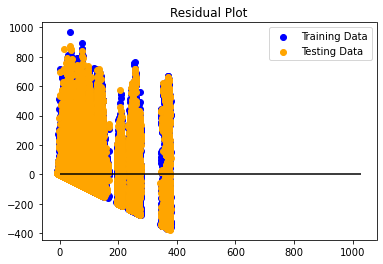

In [56]:
# Make predictions using a fitted model
# Plot the difference between the model predicted values and actual y values, versus the model predicted values
# Hint: You can predict values of X training and testing data using the model.predict() method on a fitted model

### BEGIN SOLUTION
predictions = regressor.predict(X_test_scaled)
# regressor.fit(X_train_scaled, y_train_scaled)
plt.scatter(regressor.predict(X_train_scaled), y_train - regressor.predict(X_train_scaled), c="blue", label="Training Data")
plt.scatter(regressor.predict(X_test_scaled), y_test - regressor.predict(X_test_scaled), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [57]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = regressor.score(X_test_scaled, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 4388.2291856901, R2: 0.435377481171502


In [59]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test_scaled, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 4388.170783713843, R2: 0.43538499560831545


C:\Users\chamb\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1171815.8317790031, tolerance: 732479.6433225105
  model = cd_fast.enet_coordinate_descent(


In [60]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test_scaled, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 4388.223807233445, R2: 0.43537817320412286


In [61]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test_scaled, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 4388.1448738033205, R2: 0.43538832937196414


In [62]:
from joblib import dump, load

In [63]:
dump(regressor, "model")

['model']

In [64]:
reg = load("model")

In [65]:
reg.predict(X_test_scaled)

array([[35.94973957],
       [28.44583332],
       [11.64090168],
       ...,
       [ 9.32741769],
       [-4.77487723],
       [37.62746652]])

In [66]:
dump(X_scaler, "scaler")

['scaler']

In [67]:
print(reg.intercept_)

[40.96548664]
